In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sqlfunctions import get_datapunten_voor_model


## Notities
Datapunten AI:
- omzet
- Beursgenoteerd of niet
- sector (nacebel code)
- aantal personeelsleden
- hoofdsteden provincies

In [15]:
# Zet alle data in pd dataframe
# dataframe.set_index('ondernemingnr', inplace=True)
# TODO: 
# - feature scaling, is dit nodig?
# - transformation pipeline, 
# - kijken welke metric het beste is voor accuracy
# - model persistence 
data = get_datapunten_voor_model()
dataframe = pd.DataFrame(data, columns=['ondernemingnr', 'omzet' ,'beursgenoteerd', 'sector', 'personeelsleden', 'hoofdsteden_provincies', 'site_aanwezig', 'pdf_aanwezig', 'score'])
dataframe

,ondernemingnr,omzet,beursgenoteerd,sector,personeelsleden,hoofdsteden_provincies,site_aanwezig,pdf_aanwezig,score
0,0664571447,28448384.0,False,Groothandel in kunstmeststoffen en andere agro...,23.0,Gent,1,1,0.000000
1,0664571447,28448384.0,False,Groothandel in kunstmeststoffen en andere agro...,23.0,Gent,1,1,0.000000
2,0403848513,29462877.0,False,"Vervaardiging van platen, vellen, buizen en pr...",45.0,Antwerpen,1,1,0.003483
3,0403848513,29462877.0,False,"Vervaardiging van platen, vellen, buizen en pr...",45.0,Antwerpen,1,1,0.053218
4,0403848513,29462877.0,False,"Vervaardiging van platen, vellen, buizen en pr...",45.0,Antwerpen,1,1,0.000000
...,...,...,...,...,...,...,...,...,...
63321,0479340544,0.0,False,Exploitatie van culturele centra en multifunct...,30.0,Antwerpen,1,1,0.000000
63322,0479340544,0.0,False,Exploitatie van culturele centra en multifunct...,30.0,Antwerpen,1,1,0.000000
63323,0402851787,0.0,False,Eetgelegenheden met beperkte bediening,175.0,Oudenaarde,1,1,0.000000
63324,0402851787,0.0,False,Eetgelegenheden met beperkte bediening,175.0,Oudenaarde,1,1,0.000000


In [16]:
# score als sum van alle scores
dataframe = dataframe.groupby('ondernemingnr').agg({'omzet': 'first', 'beursgenoteerd': 'first', 'sector': 'first', 'personeelsleden': 'first', 'hoofdsteden_provincies': 'first', 'site_aanwezig': 'first', 'pdf_aanwezig': 'first', 'score': 'sum'}).reset_index()


In [4]:
dataframe.set_index('ondernemingnr', inplace=True)


In [17]:
print(dataframe["site_aanwezig"].value_counts())
print(dataframe["pdf_aanwezig"].value_counts())

# rows that both have a site and a pdf
len(dataframe[(dataframe['site_aanwezig'] == 1) & (dataframe['pdf_aanwezig'] == 1)])

1    9017
0    3985
Name: site_aanwezig, dtype: int64
1    12475
0      527
Name: pdf_aanwezig, dtype: int64


8490

In [29]:
dataframe.info()
dataframe.describe()

# find edge cases


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13002 entries, 0 to 13001
Data columns (total 9 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   ondernemingnr           13002 non-null  object 
 1   omzet                   13002 non-null  float64
 2   beursgenoteerd          13002 non-null  bool   
 3   sector                  13002 non-null  object 
 4   personeelsleden         13002 non-null  float64
 5   hoofdsteden_provincies  13002 non-null  object 
 6   site_aanwezig           13002 non-null  int64  
 7   pdf_aanwezig            13002 non-null  int64  
 8   score                   13002 non-null  float64
dtypes: bool(1), float64(3), int64(2), object(3)
memory usage: 825.4+ KB


,omzet,personeelsleden,site_aanwezig,pdf_aanwezig,score
count,1.300200e+04,13002.000000,13002.000000,13002.000000,13002.000000
mean,1.057262e+07,37.731426,0.693509,0.959468,0.015781
std,1.922597e+07,38.205757,0.461054,0.197211,0.036343
min,0.000000e+00,3.000000,0.000000,0.000000,0.000000
25%,1.321987e+06,15.000000,0.000000,1.000000,0.002953
50%,2.724050e+06,24.000000,1.000000,1.000000,0.006690
75%,1.296500e+07,43.000000,1.000000,1.000000,0.015106
max,6.038329e+08,345.000000,1.000000,1.000000,0.631949


In [30]:
# categorize sector
dataframe["sector"] = dataframe["sector"].astype('category')
# get amount of different sectors
sectors = dataframe["sector"].cat.categories
# how are the sectors distributed ?
dataframe["sector"].value_counts()




,ondernemingnr,omzet,beursgenoteerd,sector,personeelsleden,hoofdsteden_provincies,site_aanwezig,pdf_aanwezig,score
0,0200065765,13199521.0,False,Openbaar bestuur op het gebied van het bedrijf...,27.0,Gent,1,1,0.131380
1,0200305493,18100623.0,True,Openbaar bestuur op het gebied van het bedrijf...,63.0,Aalst,1,1,0.013276
2,0200762878,9164977.0,False,Activiteiten van gezins- en bejaardenzorg aan ...,153.0,Antwerpen,0,1,0.003428
3,0200881951,8482006.0,False,Openbaar bestuur op het gebied van gezondheids...,47.0,Halle-Vilvoorde,1,1,0.043966
4,0204212714,15288774.0,False,Openbaar bestuur op het gebied van het bedrijf...,86.0,Turnhout,1,1,0.107927
...,...,...,...,...,...,...,...,...,...
12997,0899886915,878003.0,False,Dakwerkzaamheden,10.0,Antwerpen,0,1,0.002817
12998,0899901563,0.0,False,"Teelt van andere boomvruchten, kleinfruit en n...",52.0,Tielt,1,0,0.004862
12999,0899925715,34273975.0,False,Vervaardiging van andere anorganische chemisch...,23.0,Kortrijk,0,1,0.005119
13000,0899980054,5570672.0,False,Ontwerpen en programmeren van computerprogramma's,30.0,Gent,1,1,0.016008


In [31]:
# Data preprocessing
from sklearn.preprocessing import OrdinalEncoder

# encode sector
ordinal_encoder = OrdinalEncoder()
dataframe["sector"] = ordinal_encoder.fit_transform(dataframe[["sector"]])
dataframe["sector"] = dataframe["sector"].astype(int)

# encode hoofdsteden_provincies
dataframe["hoofdsteden_provincies"] = dataframe["hoofdsteden_provincies"].astype('category')
ordinal_encoder = OrdinalEncoder()
dataframe["hoofdsteden_provincies"] = ordinal_encoder.fit_transform(dataframe[["hoofdsteden_provincies"]])
dataframe["hoofdsteden_provincies"] = dataframe["hoofdsteden_provincies"].astype(int)


dataframe["beursgenoteerd"] = dataframe["beursgenoteerd"].astype('category')
dataframe["site_aanwezig"] = dataframe["site_aanwezig"].astype('category')
dataframe["pdf_aanwezig"] = dataframe["pdf_aanwezig"].astype('category')


len(dataframe[dataframe["beursgenoteerd"] == 1])
# Maar 17 beursgenoteerde bedrijven

dataframe["personeelsleden"] = dataframe["personeelsleden"].astype(int)




In [32]:
print(dataframe.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13002 entries, 0 to 13001
Data columns (total 9 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   ondernemingnr           13002 non-null  object  
 1   omzet                   13002 non-null  float64 
 2   beursgenoteerd          13002 non-null  category
 3   sector                  13002 non-null  int32   
 4   personeelsleden         13002 non-null  int32   
 5   hoofdsteden_provincies  13002 non-null  int32   
 6   site_aanwezig           13002 non-null  category
 7   pdf_aanwezig            13002 non-null  category
 8   score                   13002 non-null  float64 
dtypes: category(3), float64(2), int32(3), object(1)
memory usage: 495.7+ KB
None


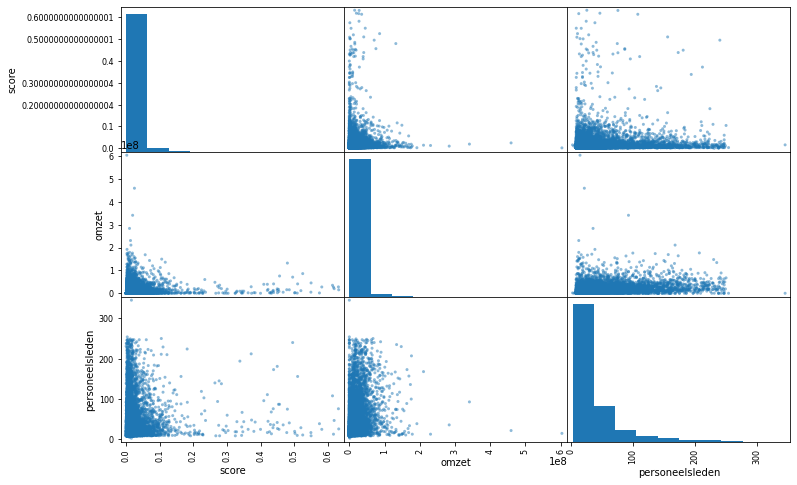

                           omzet    sector  personeelsleden  \
omzet                   1.000000  0.027021         0.366386   
sector                  0.027021  1.000000         0.068331   
personeelsleden         0.366386  0.068331         1.000000   
hoofdsteden_provincies -0.018317  0.038144        -0.012840   
score                   0.095374  0.037845         0.089986   

                        hoofdsteden_provincies     score  
omzet                                -0.018317  0.095374  
sector                                0.038144  0.037845  
personeelsleden                      -0.012840  0.089986  
hoofdsteden_provincies                1.000000 -0.038067  
score                                -0.038067  1.000000  


In [33]:
# plot correlation matrix
import matplotlib.pyplot as plt
import seaborn as sns
corr = dataframe.corr()
corr["score"].sort_values(ascending=False)
from pandas.plotting import scatter_matrix
attributes = ["score", "omzet", "personeelsleden", "beursgenoteerd"]
scatter_matrix(dataframe[attributes], figsize=(12, 8))
plt.show()


print(corr)



In [34]:
dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13002 entries, 0 to 13001
Data columns (total 9 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   ondernemingnr           13002 non-null  object  
 1   omzet                   13002 non-null  float64 
 2   beursgenoteerd          13002 non-null  category
 3   sector                  13002 non-null  int32   
 4   personeelsleden         13002 non-null  int32   
 5   hoofdsteden_provincies  13002 non-null  int32   
 6   site_aanwezig           13002 non-null  category
 7   pdf_aanwezig            13002 non-null  category
 8   score                   13002 non-null  float64 
dtypes: category(3), float64(2), int32(3), object(1)
memory usage: 495.7+ KB


![white box ml modellen](https://drek4537l1klr.cloudfront.net/thampi/HighResolutionFigures/figure_2-2.png)


In [35]:
# Model schrijven
# ! Kan pas gerund worden vanaf we alle data hebben
X = dataframe.drop(columns=["score"])
y = dataframe["score"]

# Split data into train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)


# y_train.info()
X_train.info()
y_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11701 entries, 9543 to 7270
Data columns (total 8 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   ondernemingnr           11701 non-null  object  
 1   omzet                   11701 non-null  float64 
 2   beursgenoteerd          11701 non-null  category
 3   sector                  11701 non-null  int32   
 4   personeelsleden         11701 non-null  int32   
 5   hoofdsteden_provincies  11701 non-null  int32   
 6   site_aanwezig           11701 non-null  category
 7   pdf_aanwezig            11701 non-null  category
dtypes: category(3), float64(1), int32(3), object(1)
memory usage: 446.0+ KB
<class 'pandas.core.series.Series'>
Int64Index: 1301 entries, 1078 to 4003
Series name: score
Non-Null Count  Dtype  
--------------  -----  
1301 non-null   float64
dtypes: float64(1)
memory usage: 20.3 KB


In [ ]:
X_train

: 

In [41]:
from sklearn.metrics import mean_squared_error
from sklearn import linear_model
from sklearn import svm
from sklearn.model_selection import GridSearchCV

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# TODO:
# - find out what score would be if we always predict the mean and predict 0 + compare with the scores of the models

# Linear Regression
from sklearn.linear_model import LinearRegression
print("------------- Linear Regression --------------")
lin_reg = LinearRegression()
parameters = {'fit_intercept': [True, False], 'normalize': [True, False], 'copy_X': [True, False]}
lin_reg = GridSearchCV(lin_reg, parameters, scoring="neg_mean_squared_error", cv=5)
lin_reg.fit(X_train, y_train)
y_pred_lin_reg = lin_reg.predict(X_test)
print(f"Best parameters: {lin_reg.best_params_}")
print(f"Best score: {lin_reg.best_score_}")
print(f"MSE: {mean_squared_error(y_test, y_pred_lin_reg)}")

------------- Linear Regression --------------
Best parameters: {'copy_X': True, 'fit_intercept': False, 'normalize': True}
Best score: -0.0012606132852584413
MSE: 0.0011242689344521514
------------- SVR --------------
Best parameters: {'C': 20, 'epsilon': 0.01}
Best score: -0.00133402389750133
MSE: 0.0011868003316945813
------------- BayesianRidge --------------
Best parameters: {'alpha_1': 100, 'alpha_2': 100, 'lambda_1': 100, 'lambda_2': 1}
Best score: -0.001260790193594482
MSE: 0.0011236760542244159
------------- LassoLars --------------
Best parameters: {'alpha': 0.1}
Best score: -0.0013371472040231932
MSE: 0.001181205935012302
------------- ARDRegression --------------
Best parameters: {'alpha_1': 0.0001, 'alpha_2': 100, 'lambda_1': 0.0001, 'lambda_2': 0.0001}
Best score: -0.0013174227590865089
MSE: 0.001184851111237334
------------- PassiveAggressiveRegressor --------------
Best parameters: {'C': 0.1, 'epsilon': 1}
Best score: -0.0015840646966771455
MSE: 0.0014411840660125688
--

In [ ]:


# SVR (Support Vector Regression)
from sklearn.svm import SVR
print("------------- SVR --------------")
svr_regressor = SVR(kernel='rbf', gamma="scale")
parameters = {'C': [1, 10, 20], 'epsilon': [0.1, 0.01, 0.001, 0.0001]}
svr_regressor = GridSearchCV(svr_regressor, parameters, scoring="neg_mean_squared_error", cv=5)
svr_regressor.fit(X_train, y_train)
y_pred_svr = svr_regressor.predict(X_test)
print(f"Best parameters: {svr_regressor.best_params_}")
print(f"Best score: {svr_regressor.best_score_}")
print(f"MSE: {mean_squared_error(y_test, y_pred_svr)}")



# BayesianRidge
from sklearn.linear_model import BayesianRidge
print("------------- BayesianRidge --------------")
bayesian_regressor = BayesianRidge()
parameters = {'alpha_1': [1e-06, 1e-05, 1e-04,  1, 10, 100], 'alpha_2': [1e-06, 1e-05, 1e-04,  1, 10, 100], 'lambda_1': [1e-06, 1e-05, 1e-04,  1, 10, 100], 'lambda_2': [1e-06, 1e-05, 1e-04,  1, 10, 100]}
bayesian_regressor = GridSearchCV(bayesian_regressor, parameters, scoring="neg_mean_squared_error", cv=5)
bayesian_regressor.fit(X_train, y_train)
y_pred_bay = bayesian_regressor.predict(X_test)
print(f"Best parameters: {bayesian_regressor.best_params_}")
print(f"Best score: {bayesian_regressor.best_score_}")
print(f"MSE: {mean_squared_error(y_test, y_pred_bay)}")



In [ ]:

# LassoLars
from sklearn.linear_model import LassoLars
print("------------- LassoLars --------------")
lassolars_regressor = LassoLars()
parameters = {'alpha': [0.1, 0.5, 1, 5, 10, 50, 100, 500, 1000]}
lassolars_regressor = GridSearchCV(lassolars_regressor, parameters, scoring="neg_mean_squared_error", cv=5)
lassolars_regressor.fit(X_train, y_train)
y_pred_lassolars = lassolars_regressor.predict(X_test)
print(f"Best parameters: {lassolars_regressor.best_params_}")
print(f"Best score: {lassolars_regressor.best_score_}")
print(f"MSE: {mean_squared_error(y_test, y_pred_lassolars)}")





In [ ]:
# ARDRegression
from sklearn.linear_model import ARDRegression
print("------------- ARDRegression --------------")
ard_regressor = ARDRegression()
parameters = {'alpha_1': [1e-06, 1e-05, 1e-04,  1, 10, 100], 'alpha_2': [1e-06, 1e-05, 1e-04,  1, 10, 100], 'lambda_1': [1e-06, 1e-05, 1e-04,  1, 10, 100], 'lambda_2': [1e-06, 1e-05, 1e-04,  1, 10, 100]}
ard_regressor = GridSearchCV(ard_regressor, parameters, scoring="neg_mean_squared_error", cv=5)
ard_regressor.fit(X_train, y_train)
y_pred_ard = ard_regressor.predict(X_test)
print(f"Best parameters: {ard_regressor.best_params_}")
print(f"Best score: {ard_regressor.best_score_}")
print(f"MSE: {mean_squared_error(y_test, y_pred_ard)}")


In [ ]:

# PassiveAggressiveRegressor
from sklearn.linear_model import PassiveAggressiveRegressor
print("------------- PassiveAggressiveRegressor --------------")
passive_regressor = PassiveAggressiveRegressor()
parameters = {'C': [0.1, 0.5, 1, 5, 10, 50, 100, 500, 1000], 'epsilon': [0.1, 0.5, 1, 5, 10, 50, 100, 500, 1000]}
passive_regressor = GridSearchCV(passive_regressor, parameters, scoring="neg_mean_squared_error", cv=5)
passive_regressor.fit(X_train, y_train)
y_pred_pas = passive_regressor.predict(X_test)
print(f"Best parameters: {passive_regressor.best_params_}")
print(f"Best score: {passive_regressor.best_score_}")
print(f"MSE: {mean_squared_error(y_test, y_pred_pas)}")


In [ ]:

# TheilSenRegressor
from sklearn.linear_model import TheilSenRegressor
print("------------- TheilSenRegressor --------------")
theil_regressor = TheilSenRegressor()
parameters = {'max_subpopulation': [100, 500, 1000, 5000, 10000, 50000, 100000, 500000]}
theil_regressor = GridSearchCV(theil_regressor, parameters, scoring="neg_mean_squared_error", cv=5)
theil_regressor.fit(X_train, y_train)
y_pred_seil = theil_regressor.predict(X_test)
print(f"Best parameters: {theil_regressor.best_params_}")
print(f"Best score: {theil_regressor.best_score_}")
print(f"MSE: {mean_squared_error(y_test, y_pred_seil)}")



In [ ]:
# RANSACRegressor
from sklearn.linear_model import RANSACRegressor
print("------------- RANSACRegressor --------------")
ransac_regressor = RANSACRegressor()
parameters = {'min_samples': [1, 5, 10, 50, 100, 500, 1000], 'max_trials': [100, 500, 1000, 5000, 10000, 50000, 100000, 500000]}
ransac_regressor = GridSearchCV(ransac_regressor, parameters, scoring="neg_mean_squared_error", cv=5)
ransac_regressor.fit(X_train, y_train)
y_pred_ransac = ransac_regressor.predict(X_test)
print(f"Best parameters: {ransac_regressor.best_params_}")
print(f"Best score: {ransac_regressor.best_score_}")
print(f"MSE: {mean_squared_error(y_test, y_pred_ransac)}")

In [ ]:
# ridge regression
from sklearn.linear_model import Ridge
print("------------- Ridge regression --------------")
ridge = Ridge()
parameters = {'alpha': [0.1, 0.5, 1, 5, 10, 50, 100, 500, 1000]}
ridge_regressor = GridSearchCV(ridge, parameters, scoring="neg_mean_squared_error", cv=5)
ridge_regressor.fit(X_train, y_train)
y_pred_ridge = ridge_regressor.predict(X_test)
print(f"Best parameters: {ridge_regressor.best_params_}")
print(f"Best score: {ridge_regressor.best_score_}")
print(f"MSE: {mean_squared_error(y_test, y_pred_ridge)}")

# Lasso regression
from sklearn.linear_model import Lasso
print("------------- Lasso regression --------------")
lasso = Lasso()
parameters = {'alpha': [0.1, 0.5, 1, 5, 10, 50, 100, 500, 1000]}
lasso_regressor = GridSearchCV(lasso, parameters, scoring="neg_mean_squared_error", cv=5)
lasso_regressor.fit(X_train, y_train)
print(lasso_regressor.best_params_)
print(lasso_regressor.best_score_)
y_pred_lasso = lasso_regressor.predict(X_test)
print(f"MSE: {mean_squared_error(y_test, y_pred_lasso)}")


In [37]:
# appart want deze gridsearch duurt lang
from sklearn.metrics import mean_squared_error

# Random forest regression
from sklearn.ensemble import RandomForestRegressor
print("------------- Random forest regression --------------")
random_forest_regressor = RandomForestRegressor(n_estimators=500, max_depth=20)
# parameters = {'n_estimators': [200, 500, 1000], 'max_depth': [2, 3, 5, 10, 15, 20, 30, 50, 100]}
# random_forest_regressor = GridSearchCV(random_forest_regressor, parameters, scoring='neg_mean_squared_error', cv=5)
random_forest_regressor.fit(X_train, y_train)
# print(random_forest_regressor.best_params_)
# print(random_forest_regressor.best_score_)
y_pred_random = random_forest_regressor.predict(X_test)
print(f"MSE: {mean_squared_error(y_test, y_pred_random)}")

------------- Random forest regression --------------
MSE: 0.001176029871453432


In [ ]:
# R2 scores berekenen voor elk model
from sklearn.metrics import r2_score
print("------------- R2 scores --------------")
print(f"R2 score linear regression: {r2_score(y_test, y_pred_lin_reg)}")
print(f"R2 score ridge regression: {r2_score(y_test, y_pred_ridge)}")
print(f"R2 score lasso regression: {r2_score(y_test, y_pred_lasso)}")
print(f"R2 score passive aggressive regression: {r2_score(y_test, y_pred_pas)}")
print(f"R2 score theil sen regression: {r2_score(y_test, y_pred_seil)}")
print(f"R2 score ransac regression: {r2_score(y_test, y_pred_ransac)}")
print(f"R2 score random forest regression: {r2_score(y_test, y_pred_random)}")


: 

In [40]:
# print random forest prediction and actual values
# for i in range(100):
#     print(y_pred[i], y_test[i])
from sklearn.metrics import r2_score

# print random forest feature importance
importances = random_forest_regressor.feature_importances_
std = np.std([tree.feature_importances_ for tree in random_forest_regressor.estimators_],
                axis=0) 
indices = np.argsort(importances)[::-1]
print("Feature ranking:")
for f in range(X_train.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))
    print(f"-> {X_train.columns[indices[f]]}")


print(f"R2 score random forest regression: {r2_score(y_test, y_pred_random)}")


Feature ranking:
1. feature 1 (0.263665)
-> omzet
2. feature 0 (0.255266)
-> ondernemingnr
3. feature 3 (0.196298)
-> sector
4. feature 4 (0.155381)
-> personeelsleden
5. feature 5 (0.077688)
-> hoofdsteden_provincies
6. feature 6 (0.047623)
-> site_aanwezig
7. feature 7 (0.002685)
-> pdf_aanwezig
8. feature 2 (0.001395)
-> beursgenoteerd
R2 score random forest regression: 0.004256693113906862


In [ ]:
# saving the best model
import pickle
filename = 'final_model.sav'
pickle.dump(random_forest_regressor, open(filename, 'wb'))

# load the model from disk
loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.score(X_test, y_test)

# make a prediction
new_data = X_test.iloc[0]
print(new_data)
loaded_model.predict([new_data])

: 